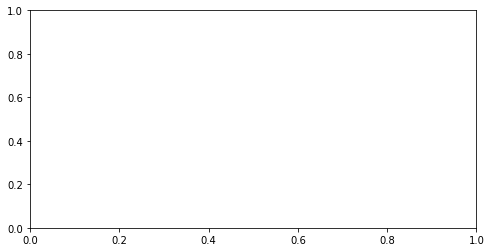

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nutil import *
# plt.style.use('ggplot')
plt.style.use('dark_background')
%load_ext autoreload

%autoreload 2


## Creating signals
  https://janboone.github.io/python_economics/economics.html#org31136ad

# Ornstein-Uhlenbeck process

In [21]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# t,x = ou_process(dt=10**(-6), r=3)
# x /= 10
# ax.plot(t, x, lw=1)

SELL, BUY = -1, 1
get_stock_total = lambda agents: np.sum(list(map(lambda d: d['stock'], agents)))
get_wealth_total = lambda agents: np.sum(list(map(lambda d: d['wealth'], agents)))

get_stock_amount = lambda d: (-1)**(d['action']['type'] == SELL)*d['action']['amount']
get_volume = lambda l: np.min([np.sum((np.array(l)>0)*l), -np.sum((np.array(l)<0)*l)])
get_volume_history = lambda: list(map(lambda l: get_volume(list(map(get_stock_amount, l))), action_history))

lmap = lambda f,l: list(map(f,l))
lfilter = lambda f,l: list(filter(f,l))

get_actions = lambda agents: lfilter(lambda o: o != None, lmap(lambda a: a.get('action'), agents))
get_strat_strength = lambda s: s.strength
get_strats = lambda agents: np.squeeze(np.reshape([agent['strats'] for agent in agents], (1,-1)))

total_bought = lambda actions: np.sum(lmap(lambda d: d['amount'], filter(lambda d: d['type'] == BUY, actions)))
total_sold = lambda actions: np.sum(lmap(lambda d: d['amount'], filter(lambda d: d['type'] == SELL, actions)))
get_ts = lambda action_df: action_df[0]['timestamp']

get_bought_sold_ts = lambda action_df: (total_bought(get_actions(action_df)),total_sold(get_actions(action_df)),get_ts(action_df))

In [25]:
m = Market()

In [26]:
m.simulate_k_steps(50)

0.00 percent done.
20.00 percent done.
40.00 percent done.
60.00 percent done.
80.00 percent done.


In [28]:
class Market:
    """Handles all variables normally. Not having a class made 
    it a nightmare to keep global variables. Also this is a bad
    class, because it handles both market logic and strat feedback.
    """
    
    def __init__(self,no_agents=150, mutate_prob=0.02):        
        self.r = 0.02/252
        self.dividend = 1./252.
        self.price = 10.
        self.c = 0.001
        self.s_min,self.s_max=-1,1
        self.eta = 0.001
        self.t,self.x = ou_process(mu = self.dividend, dt=10**(-6),r=3)
        self.dividend_with_timestamp = iter(zip(self.x,self.t))
        self.signals = []
        self.mutate_prob = mutate_prob

        self.price_history = [self.price,self.price]
        self.volume_history = [1,1]
        self.dividend_history = [self.dividend,self.dividend]
        self.action_history = []
        self.market_state_history = []
        self.ts_history = [] #tmp dealing with some bug
        self.mutate_history = []

        self.no_agents = no_agents
        self.agents = [create_agent() for _ in range(self.no_agents)]
        self.stock_total = self.no_agents*10.
        self.market_state = []
        self.B,self.O,self.V = 0.,0.,0.
        
        self.create_signals()
        self.update_market_state()

    def update_market_state(self):
        self.market_state = np.array([signal_dict['signal']() for signal_dict in self.signals])
        
    def feedback_all(self):
        for agent in self.agents:
            for strat in agent['strats']:
                self.feedback(strat)
                
    def clear(self, agent: dict, verbose: bool = False) -> dict:
        """Transacts each agent's action and sets new action to None

        Order is important:
            1) cash earns r
            2) stock price change changes wealth
            3) stock is bought/sold (liquidity changes inherently)

        Aka Clearing House function
        """
        def calculate_agent_cash(agent: dict) -> float:
                """Return the liquidity of an agent. How much stock can be bought."""
                return agent['wealth'] - agent['stock'] * self.price

        agent['wealth'] += self.dividend * agent['stock']/self.stock_total

        if agent.get('action') == None or self.B == 0 or self.O == 0:
            return agent

        stock_diff = (agent['action']['type']==BUY) * self.V/self.B * agent['action']['amount'] -\
            (agent['action']['type']==SELL) * self.V/self.O * agent['action']['amount']
        agent['timestamp'] = self.ts
        agent['wealth'] += calculate_agent_cash(agent) * self.r #cash earned risk free rate
        agent['wealth'] += agent['stock'] * (self.price-self.price_history[-1]) # how much stock worth changed.
        agent['stock'] += stock_diff #buy/sell happens at new price
        if agent['stock'] < 0. or agent['wealth'] < 0.:
            print(self.ts, agent['wealth'], agent['stock'])
            assert False
        if verbose:
            print("Agent aquired dividend wealth: %s" % (self.dividend * agent['stock']/self.stock_total))
            print("Stock diff is %s" % stock_diff)
        agent.pop('action')
        return agent
    
    def transact(self, agents: list, verbose: bool = False) -> list:
        """Clear all transactions.

        Return: deepcopied agents with cleared transactions and removed action from dict

        If there are more buy bids then fraction of all gets through.
        This is the rationing scheme mentioned in the paper.

        B - bid total
        O - offer total
        V - volume (minimum of O, B)
        """

#         global price, stock_total, dividend, B, O, V, ts
        self.dividend, self.ts = next(self.dividend_with_timestamp)
        self.dividend = max(0,self.dividend)
        self.ts_history.append((self.dividend, self.ts))
        agents = list(map(copy, agents))

        iter_t = lambda action_type: filter(lambda d: d.get('action', {}).get('type') == action_type, agents)
        buyers = list(iter_t(1))
        sellers = list(iter_t(-1))

        self.B = np.sum(list(
            map(lambda d: d['action']['amount'],
            buyers)
        ))
        self.O = np.sum(list(
            map(lambda d: d['action']['amount'],
            sellers)
        ))
        self.V = min(self.B,self.O)
        if (self.V > 0. and verbose):
            print("transaction happened: B=%s,O=%s"%(B,O))

        #oldprice = self.price
        #TODO: Is this where signals ought to be called?
        self.price *= 1 + self.eta*(self.B-self.O)
        self.price_history.append(self.price)
        self.volume_history.append(self.V)
        self.dividend_history.append(self.dividend)

        #print('After transacting (B=%s ;O=%s), %.3f -> %.3f ' % (self.B,self.O,oldprice,self.price) )

        return list(map(self.clear, agents))
    
    def feedback(self, strat):
        if not strat.is_activated(self.market_state):
            k = np.random.choice([0,1,2,3,4],p=[1-self.mutate_prob,self.mutate_prob/4,self.mutate_prob/4,self.mutate_prob/4,self.mutate_prob/4])
            strat.mutate_existing(k=k)
            if k > 0: self.mutate_history.append({'time':self.ts,'strat':strat.name,'agent':strat.agent})
            #if k > 0: print(strat.name)
        if strat.is_activated(self.market_state):
            strat.strength = (1-self.c)*strat.strength + self.c*strat.action*(self.price_history[-1]-(1+self.r)*self.price_history[-2]+self.dividend_history[-1])
            strat.strength = max(min(self.s_max, strat.strength),self.s_min)
            if strat.strength < -0.3:
                #print('inverted', strat.name)
                strat.strength = 0.3
                strat.action *= -1
                
                
    def create_and_add_signal(self, description: str, formula) -> dict:
            """Add dict market signal object with description and signal"""
            self.signals.append({'description': description, 'signal': formula})
            
    def fundamental_value(self):
        """p[t] == dividend/risk_free_rate"""
        return self.dividend/(self.r)
        
    def create_signals(self):
        """Fundamental price signal"""
        s = 'Price is over %s times fundamental value'
        for ratio in np.round(np.linspace(0.25,4.25,8),1):
            self.create_and_add_signal(
                description = s % ratio,
                formula = lambda ratio=ratio: self.price > ratio * self.fundamental_value()
            )

        """Avg relative signal compared to last k days"""
        s = 'Price is over %s times last %s timestep avg'
        for k in np.linspace(1,17,5).astype(np.int64):
            for ratio in np.round(np.linspace(0.5,1.5,5),1):
                self.create_and_add_signal(
                    description = s % (ratio, k),
                    formula = lambda ratio=ratio,k=k: self.price > ratio * np.mean(self.price_history[-k:])
                )

        """Std volatility signal"""
        s = 'Stdev is more than %s over last %s timesteps'
        for k in np.linspace(5,17,3).astype(np.int64):
            for stdev_norm in np.round(np.linspace(0.001,100,2),1):
                self.create_and_add_signal(
                    description = s % (stdev_norm, k),
                    formula = lambda stdev_norm=stdev_norm,k=k: stdev_norm < np.std(self.price_history[-k:])
                )

        """Volume signal"""
        s = 'Volume is more than %s over last %s timestep avg'
        for k in np.linspace(1,5,4).astype(np.int64):
            for vol_norm in np.round(np.linspace(0.01,5,5),1):
                self.create_and_add_signal(
                    description = s % (vol_norm, k),
                    formula = lambda vol_norm=vol_norm,k=k: vol_norm < np.mean(self.volume_history[-k:])
                )
        
    def simulate_k_steps(self, k: int = 1):
        for i in range(k):
            self.market_state_history.append(self.market_state)
            self.agents = self.transact(self.agents)
            self.update_market_state()
            self.feedback_all()
            self.set_next_actions(self.agents)
            self.action_history.append(copy(self.agents))
            if int(100*(i/k)) % 20 == 0 and k > 20 and i % 10 == 0:
                print("%.2f percent done." % int(100*(i/k)) )  
            
    def set_next_actions(self, agents: list) -> None:
        """Set random actions within boundaries (no short selling, negative wealth)"""
        def set_next_action(agent: dict) -> None:
            def calculate_agent_cash(agent: dict) -> float:
                """Return the liquidity of an agent. How much stock can be bought."""
                return agent['wealth'] - agent['stock'] * self.price
            def get_action_within_boundaries(agent, action_type, amount_wish):
                """Avoids selling short and having negative wealth."""
                return min(amount_wish, agent['stock']) \
                      if action_type == SELL \
                      else max(0,min(self.price * amount_wish, calculate_agent_cash(agent)))/self.price
            def select_random_activated_strategy(agent, market_state):
                def create_activated_strategy(market_state):
                    indices = np.random.choice(range(len(self.signals)), replace=False, size=np.random.randint(low=1,high=len(self.signals)))
                    condition = market_state[indices]
                    return Strategy(indices, condition)

                activated_strats = list(filter(
                    lambda strat: strat.is_activated(market_state) and strat.strength > 0.,
                    agent['strats']
                ))
                if len(activated_strats) == 0:
#                   new_strat = create_activated_strategy(market_state)
#                   mutate_strats = np.array((agent['strats']))[
#                     np.argsort(np.abs(list(map(lambda a: a.strength,agent['strats']))))[:10]
#                   ]
#                   for strat in mutate_strats:
#                       strat.mutate_existing(k=5)
                    return None #new_strat
                get_strat_strength = lambda s: s.strength
                norm_const = np.sum(lmap(get_strat_strength, activated_strats))
                activated_strat = np.random.choice(activated_strats, p = lmap(get_strat_strength, activated_strats)/norm_const)
                return activated_strat
            selected_strat = select_random_activated_strategy(agent, self.market_state)
            if selected_strat == None:
                return None
            action_type = selected_strat.action
            amount_wish = 2.
            real_amount = get_action_within_boundaries(agent, action_type, amount_wish)
            agent['action'] = {'type': action_type, 'amount': real_amount}
        list(filter(lambda agent: agent != None, map(set_next_action, agents)))

from strategy import *
from uuid import uuid4 as UUID
import numpy as np
from copy import deepcopy as copy
from util import ou_process

lmap = lambda f,l: list(map(f,l))
lfilter = lambda f,l: list(filter(f,l))
get_bought_sold_ts = lambda action_df: (total_bought(get_actions(action_df)),total_sold(get_actions(action_df)),get_ts(action_df))
total_bought = lambda actions: np.sum(lmap(lambda d: d['amount'], filter(lambda d: d['type'] == BUY, actions)))
total_sold = lambda actions: np.sum(lmap(lambda d: d['amount'], filter(lambda d: d['type'] == SELL, actions)))
get_ts = lambda action_df: action_df[0]['timestamp']
get_actions = lambda agents: lfilter(lambda o: o != None, lmap(lambda a: a.get('action'), agents))
get_strat_strength = lambda s: s.strength
get_strats = lambda agents: np.squeeze(np.reshape([agent['strats'] for agent in agents], (1,-1)))

SELL, BUY = -1, 1

def clear(agent: dict, verbose: bool = False) -> dict:
        """Transacts each agent's action and sets new action to None


In [3]:
import numpy as np
import cupy as cp
import time

In [12]:
def test_function(arr):
    arr_gpu = cp.array(arr)
    arr_gpu += 1
    out_host = cp.asnumpy(arr_gpu)

    # this has no effect
    del arr_gpu
    cp._default_memory_pool.free_all_blocks()

    return out_host

In [19]:
del(x_gpu)
cp._default_memory_pool.free_all_blocks()

In [18]:
### Numpy and CPU
s = time.time()
x_cpu = np.ones((1000,1000,1000))
e = time.time()
print(e - s)### CuPy and GPU
s = time.time()
x_gpu = cp.ones((1000,1000,100))
cp.cuda.Stream.null.synchronize()
e = time.time()
print(e - s)

3.6629629135131836
0.3508777618408203


In [5]:
# fig = plt.figure()
# plt.plot(m.price_history[:200])
# fig.savefig('start_sell_higher_why_smooth.png', dpi=fig.dpi)

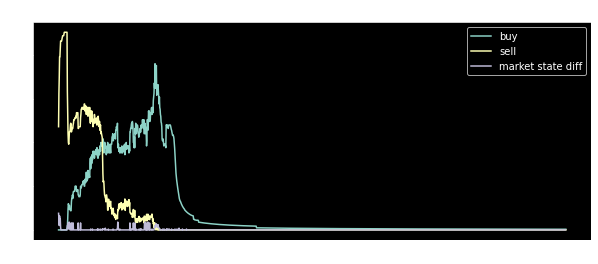

In [8]:
df = pd.DataFrame(lmap(get_bought_sold_ts, m.action_history))

df.columns = ['buy','sell','ts']

plt.figure(figsize=(10,4))
plt.title("Buy/sell")
plt.plot(df.buy,label='buy')
plt.plot(df.sell,label='sell')
plt.plot(np.sum(np.diff(m.market_state_history,axis=0),axis=1),label='market state diff')
plt.legend(loc="upper right");

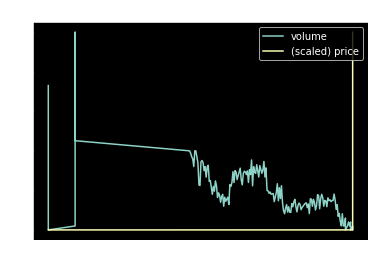

In [19]:
plt.title("Scaled price change and vol")
plt.plot(df.ts,m.volume_history[2:],label='volume')
plt.plot(df.ts,(m.price_history/(np.max(m.price_history)/np.max(m.volume_history)))[2:],label='(scaled) price')
plt.legend(loc="upper right");

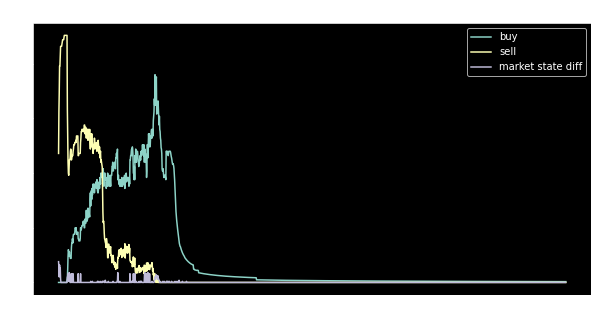

In [16]:
df = pd.DataFrame(lmap(get_bought_sold_ts, m.action_history))

df.columns = ['buy','sell','ts']

plt.figure(figsize=(10,5))
plt.title("Action buy/sell")
plt.plot(df.buy,label='buy')
plt.plot(df.sell,label='sell')
plt.plot(np.sum(np.diff(m.market_state_history,axis=0),axis=1),label='market state diff')
plt.legend(loc="upper right");

In [37]:
len(buy)

1500

In [38]:
len(m.market_state_history)

1500

In [42]:
df2 = pd.DataFrame(m.mutate_history)

In [48]:
lmap(lambda t: t[1], m.ts_history)[317]

0.00031700031700031695

In [55]:
df2.time.value_counts()

0.000294    213
0.000382    211
0.000036    208
0.000062    207
0.000364    206
           ... 
0.001352    137
0.000432    136
0.000170    131
0.000731    130
0.001125    124
Name: time, Length: 1500, dtype: int64

In [54]:
df2[df2.time == 0.00031700031700031695]

,time,strat,agent
55041,0.000317,0d542e7d-0f86-4505-9335-685f5fc1e7b4,6a3649b0-984f-426f-9cab-37e886ca58f1
55042,0.000317,71c58760-d5a0-4503-8e24-58daa6cbcb1c,6e5e343e-e3bb-4fe3-9253-048386170e45
55043,0.000317,c69661c3-282b-4be7-8f31-9a1dab091842,7faec373-c404-427d-a4a2-3feea102b235
55044,0.000317,fbe14dba-e920-4046-a34d-18cb2e059326,7faec373-c404-427d-a4a2-3feea102b235
55045,0.000317,9b706e23-76ef-40a7-a6ff-6ce672194892,0004de78-a979-4f53-967e-5415ea1ebc77
...,...,...,...
55210,0.000317,a3a952ca-d53c-4de0-a840-130839de27f3,24693826-4dd0-494e-96d5-960088974769
55211,0.000317,a02f8d86-7984-4992-871f-4f122a8d8d89,cb8546ca-6975-4153-a523-694eeff0a441
55212,0.000317,f0bd542b-f042-4a42-bd4f-62931ebde8d3,72c57e71-e9ae-447c-9032-bbbe9d6c1472
55213,0.000317,1f15e6ea-4765-4afe-a02f-e0ca769307f5,c8733bb0-7b7f-42dd-9b29-5f80b0d458b6


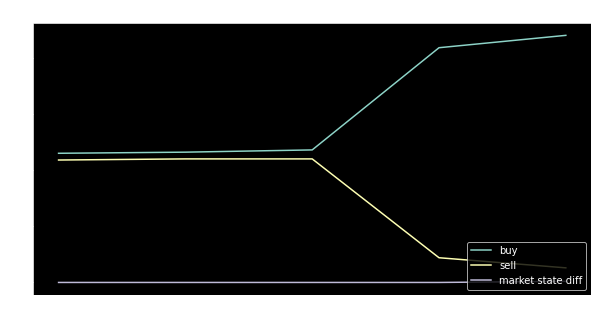

In [39]:
# get_activated_no = lambda k, act: len(lfilter(
#     lambda st: st.action == act and st.is_activated(m.market_state_history[k]), 
#     np.squeeze(np.reshape(lmap(lambda d: d['strats'], m.action_history[k]), (1,-1)))
# ))

# buysellstrats = np.transpose([(get_activated_no(k,1),get_activated_no(k,-1)) for k in range(len(m.action_history))])
# buy = buysellstrats[0]
# sell = buysellstrats[1]

plt.figure(figsize=(10,5))
plt.title("Strategy buy/sell")
a,b = 315,320
plt.plot(buy[a:b], label = 'buy')
plt.plot(sell[a:b], label = 'sell')
plt.plot(np.sum(np.diff(m.market_state_history,axis=0),axis=1)[a:b],label='market state diff')
plt.legend(loc="lower right");

### Let's try to duplicate market object up until this timestep:

In [70]:
import pickle

In [ ]:
pi

In [61]:
m2 = Market()
m2.agents = m.action_history[318]

m2.action_history = m.action_history[:318]
m2.price_history = m.price_history[:318]
m2.volume_history = m.volume_history[:318]
m2.dividend_history = m.dividend_history[:318]
m2.market_state_history = m.market_state_history[:318]
m2.ts_history = m.ts_history[:318]
m2.mutate_history = m.mutate_history[:318]

m2.market_state = m.market_state_history[318]

iter_t = lambda action_type: filter(lambda d: d.get('action', {}).get('type') == action_type, m2.agents)
buyers = list(iter_t(1))
sellers = list(iter_t(-1))
m2.B = np.sum(list(
    map(lambda d: d['action']['amount'],
    buyers)
))
m2.O = np.sum(list(
    map(lambda d: d['action']['amount'],
    sellers)
))
m2.V = min(m2.B,m2.O)

In [67]:
# test
get_activated_no2 = lambda k, act: len(lfilter(
    lambda st: st.action == act and st.is_activated(m2.market_state_history[k]), 
    np.squeeze(np.reshape(lmap(lambda d: d['strats'], m2.action_history[k]), (1,-1)))
))

print(get_activated_no2(317,1),get_activated_no2(317,-1))
print(get_activated_no(317,1),get_activated_no(317,-1))
print(get_activated_no(318,1),get_activated_no(318,-1))

118 110
118 110
209 22


In [68]:
m2.simulate_k_steps(1)

In [69]:
print(get_activated_no2(318,1),get_activated_no2(318,-1))

204 23


### What kind of signals are changing in market state?

In [8]:
signal_diffs = np.array(m.market_state_history[1:])[
    np.sum(np.diff(m.market_state_history,axis=0),axis=1)>0
]

In [9]:
np.squeeze(np.argwhere(np.sum(np.diff(m.market_state_history,axis=0),axis=1)>0))

array([  0,   1,   2,   5,   9,  11,  13,  14,  15,  16,  17,  18,  20,
        21,  23,  25,  27,  31,  36,  38,  41,  45,  49,  55,  56,  57,
        59,  60,  69,  71,  72,  76,  79,  81,  83,  84,  87,  91,  92,
        94,  98, 101, 102, 104, 105, 108, 109, 111, 112, 113, 115, 116,
       118, 119, 120, 121, 122, 123, 125, 126, 128, 129, 131, 132, 134,
       135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163,
       164, 165, 166, 167, 169, 170, 171, 172, 174, 176, 177, 183, 184,
       187, 189, 192, 195, 200, 203, 207, 218, 225, 228, 229, 236, 239,
       250, 252, 266, 270, 271, 274, 275, 278, 298, 301, 319, 320, 323,
       324, 327, 330, 335, 336, 337, 339, 340, 341, 342, 343, 355, 356,
       358, 359, 363, 364, 366, 367, 368, 369, 376, 381, 382, 385, 392,
       393, 396, 416, 417, 438, 439, 441, 442, 475, 477, 481, 482, 484,
       490, 493, 496, 497, 499, 501, 504, 505, 512, 520, 536, 54

In [44]:
#First 5
list(
    df.ts[np.squeeze(np.argwhere(np.sum(np.diff(m.market_state_history,axis=0),axis=1)>0))]
)[:5]

[0.0,
 0.00010400010400010399,
 0.00010400010400010399,
 0.00010600010600010599,
 0.00010600010600010599]

In [45]:
pd.Series(lmap(lambda d: d['description'], np.array(m.signals))).value_counts()[:10]

Price is over 1.2 times last 9 timestep avg         1
Price is over 1.1 times last 13 timestep avg        1
Price is over 0.8 times last 13 timestep avg        1
Price is over 1.4 times last 9 timestep avg         1
Volume is more than 5.0 over last 3 timestep avg    1
Volume is more than 0.0 over last 2 timestep avg    1
Price is over 1.4 times fundamental value           1
Price is over 1.0 times last 13 timestep avg        1
Price is over 0.7 times last 1 timestep avg         1
Volume is more than 1.3 over last 1 timestep avg    1
dtype: int64

In [80]:
lmap(lambda d: d['description'], np.array(m.signals)[signal_diffs[1]])

['Price is over 0.2 times fundamental value',
 'Price is over 0.8 times fundamental value',
 'Price is over 1.4 times fundamental value',
 'Price is over 2.0 times fundamental value',
 'Price is over 2.5 times fundamental value',
 'Price is over 3.1 times fundamental value',
 'Price is over 3.7 times fundamental value',
 'Price is over 4.2 times fundamental value']

In [13]:
for k in np.linspace(1,5,4).astype(np.int64):
    for vol_norm in np.round(np.linspace(0.01,5,5),1):
        print(k, vol_norm)

1 0.0
1 1.3
1 2.5
1 3.8
1 5.0
2 0.0
2 1.3
2 2.5
2 3.8
2 5.0
3 0.0
3 1.3
3 2.5
3 3.8
3 5.0
5 0.0
5 1.3
5 2.5
5 3.8
5 5.0


## Visualisation tools

How to investigate:

- single timestamp
    - how many buyers / sellers
    - how many active strategies
    - how difficult strategies
- single agent
    - how many active strategies
    - profit
- single strategy
    - strength
    - potential profit (if always chosen) ~ already directly correlated to strength?
    
### TODO:

If multiple strats active, don't have stocks/liquidity -> only buy/

In [8]:
lmap(get_strat_strength, get_strats(m.action_history[0]))[301]

0.05

In [10]:
pd.Series(list(map(lambda d: str(d.keys()), m.action_history[-1]))).value_counts()

dict_keys(['name', 'strats', 'wealth', 'stock', 'timestamp', 'action'])    46
dict_keys(['name', 'strats', 'wealth', 'stock', 'timestamp'])               4
dtype: int64

In [11]:
bs = get_strats(m.agents)[1489]

In [78]:
v = lmap(lambda s: np.sum(lmap(s.is_activated, m.market_state_history)), get_strats(m.agents))

In [80]:
pd.Series(v).value_counts() # absolutely no changes to strats

0       2305
1210     195
dtype: int64

In [63]:
np.argsort(lmap(get_strat_strength, get_strats(m.agents)))

array([2430, 2188,  779, ...,  301,   38, 1844])

In [154]:
pd.DataFrame(lfilter(lambda d: d.get('action') != None and d.get('action').get('amount') != 0.,m.action_history[-1]))

,name,strats,wealth,stock,timestamp,action
0,1701ef8f-9e27-4a59-a6ea-c2ecb85ebcd7,[---\nMarket indicators: [ 1 5 8 13 15 22 26...,10026.645538,30.158938,0.000031,"{'type': 1, 'amount': 0.998888180741205}"
1,55258d0d-b9d0-43b1-b300-2d23d1a70b52,[---\nMarket indicators: [ 1 2 5 7 9 11 15...,10026.645538,30.158938,0.000031,"{'type': 1, 'amount': 0.998888180741205}"
2,ab1f1586-c486-4307-be5a-701404f7d3c6,[---\nMarket indicators: [13 16 18 21 23 28 34...,10025.856885,3.004313,0.000031,"{'type': 1, 'amount': 0.998888180741205}"
3,e0a0743a-0ac1-415e-9d75-931009093eb9,[---\nMarket indicators: [ 2 3 5 6 9 11 12...,10026.645538,30.158938,0.000031,"{'type': 1, 'amount': 0.998888180741205}"
4,d1eb06bf-9ccf-44ef-b77f-290ba3fb4311,[---\nMarket indicators: [ 0 2 3 6 8 11 15...,10019.118996,19.372393,0.000031,"{'type': 1, 'amount': 0.998888180741205}"
5,b0d10741-2ba5-47ee-9aaf-c69601d7bcfc,[---\nMarket indicators: [ 0 2 4 5 6 7 8...,10025.790867,2.323497,0.000031,"{'type': 1, 'amount': 0.998888180741205}"
6,7cef3ee7-e82c-4261-b71d-552f4222473e,[---\nMarket indicators: [ 1 2 3 4 7 12 16...,10025.749417,1.205231,0.000031,"{'type': -1, 'amount': 1}"
7,d34c6b7c-5644-4ab3-9982-c2315cddc601,[---\nMarket indicators: [ 3 4 6 7 8 9 10...,10026.561142,28.373224,0.000031,"{'type': 1, 'amount': 0.998888180741205}"
8,00e004a9-e408-4b6b-a526-4153b878dc49,[---\nMarket indicators: [ 0 1 2 3 4 5 6...,10026.645538,30.158938,0.000031,"{'type': 1, 'amount': 0.998888180741205}"
9,77ac5e09-342d-4893-91a6-dccde0afb11c,[---\nMarket indicators: [ 4 11 18 20 55 63 82...,10026.645538,30.158938,0.000031,"{'type': 1, 'amount': 0.998888180741205}"


In [ ]:
allstrats = np.reshape(np.c_[lmap(lambda a: a['strats'], fa)], 4000)

In [ ]:
lfilter(lambda s: s.strength>0.8 and s.is_activated(market_state), allstrats)

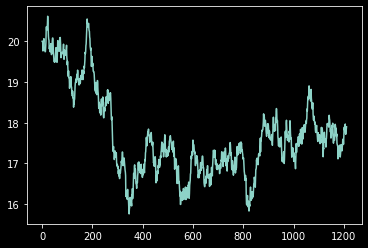

In [77]:
# plt.plot(m.price_history, label='Price')
# plt.plot(np.array(m.volume_history)*2, label='Volume')
plt.plot(np.array(m.dividend_history)*20, label='Dividend')